In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np
import pandas as pd

In [3]:
#!unzip voicegender.zip

In [4]:
df_voice = pd.read_csv('voice.csv')
print(df_voice.columns)
label_value_counts = df_voice.label.value_counts()
print(label_value_counts)
print(df_voice.info())
df_voice.head()

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')
female    1584
male      1584
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null float64
maxdom      3168 non

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [5]:
# Convert label from string to number: male: 1, female: 0
dict = {
    'label': {
        'male': 1, 
        'female': 0
    }
}
df_voice.replace(dict, inplace=True)
x = df_voice.loc[:, df_voice.columns != 'label']
y = df_voice.loc[:, 'label']

In [6]:
# Create Random Forest Classifier and 5 Fold Cross Validation
# In K fold cross validation, data set is divided into K subsets and method is repeated K times.
# Each time one of the K subset is used for test set and others are training set.
# After that, average accuracy across all K trials is computed

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)
cross_validator = StratifiedKFold(n_splits=5, shuffle=False)

In [15]:
class ROC:
    def __init__(self, x, y, k_folds=5):
        
        self.true_positive_rates = []
        self.aucs = []
        self.mean_false_positive_rates = np.linspace(0, 1, 100)
        
        self.k_folds = k_folds
        self.x = x
        self.y = y
        
    def fit_and_draw(self):
        
        fig1 = plt.figure(figsize=[12, 12])
        ax1 = fig1.add_subplot(111, aspect='equal')
        ax1.add_patch(patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5))
        ax1.add_patch(patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5))
        
        cross_validator = StratifiedKFold(n_splits=self.k_folds, shuffle=False)
        i = 1
        for train, test in cross_validator.split(self.x, self.y):
            prediction = classifier.fit(self.x.iloc[train], self.y.iloc[train]).predict_proba(self.x.iloc[test])
            print("Shape of Train: {0}, Test: {1}, Prediction: {2}".format(train.shape, test.shape, prediction.shape))
            false_positive_rate, true_positive_rate, t = roc_curve(self.y[test], prediction[:, 1])
            print("Shape of FPR: {0}".format(false_positive_rate.shape))
            interpolated = interp(self.mean_false_positive_rates, false_positive_rate, true_positive_rate)
            print("Shape of Inerpolated: {0}".format(interpolated.shape))
            self.true_positive_rates.append(interpolated)
            roc_auc = auc(false_positive_rate, true_positive_rate)
            self.aucs.append(roc_auc)
            plt.plot(false_positive_rate, true_positive_rate, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i = i + 1
            
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
        mean_true_positive_rate = np.mean(self.true_positive_rates, axis=0)
        mean_auc = auc(self.mean_false_positive_rates, mean_true_positive_rate)

        plt.plot(self.mean_false_positive_rates, mean_true_positive_rate, color='blue', label=r'Mean RCO ( AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc='lower right')
        plt.text(0.32, 0.7, 'More Accurate Area', fontsize=12)
        plt.text(0.63, 0.4, 'Less Accurate Area', fontsize=12)
        plt.show()


Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (12,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (11,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (11,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (10,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (12,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (12,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (8,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (7,)
Shape of Inerpolated: (100,)
Shape of Train: (2956,), Test: (212,), Prediction: (212, 2)
Shape of FPR: (11,)
Shape of Inerpolated: (100,)
Shape of Train: (2958

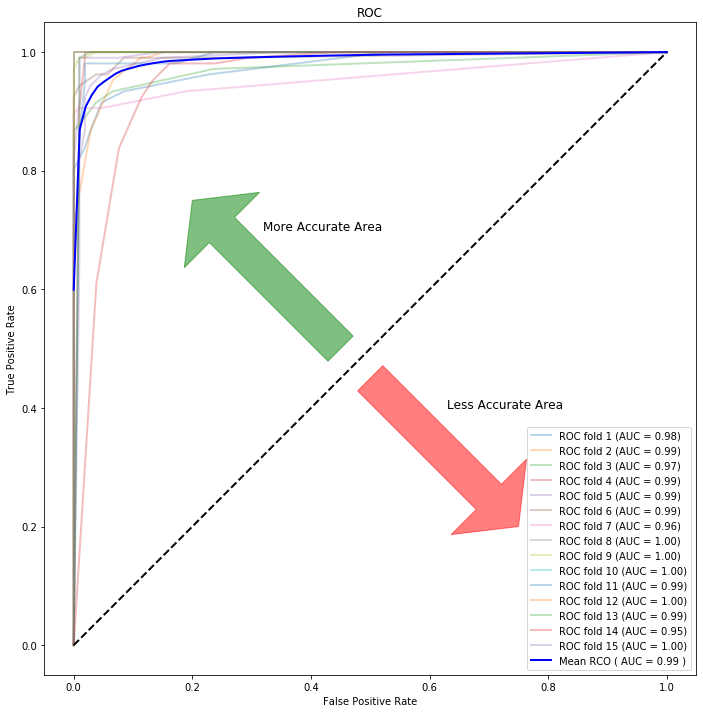

In [16]:
roc = ROC(x, y, 15)
roc.fit_and_draw()